In [1]:
import math
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.transforms as T
import geopandas as gpd
import pandas as pd
import momepy
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=False)

from utils import remove_item, load_graph, criteria_fns
from prediction import run, load_data
from utils.constants import *
!nvidia-smi

/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Mon Jun 13 20:24:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:02:00.0 Off |                  N/A |
| 47%   43C    P0    31W / 105W |   1430MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# torch.save(model_dict, './model_dict.pt')
model_dict = torch.load('./model_dict.pt')

In [ ]:
place = 'No Bounds'
model_dict = {}
result_dict = {}


for var_args in [
    'minmax',
    'maxabs',
    'robust',
    'power',
    'sum'
]:  
    data_process_args = {
        'scaler': var_args,
        'clean': False,
        'include_feats': unnorm_feature_fields,
        'split_approach': 'neighbor', 
        'batch_size':  4096 ,
    }
    model_args = {
        'model_type': 'sage',
        'num_layers': 2,
        'aggr': 'min',
        'hidden_channels': 20
    }
    print(f'Testing {var_args}')
    models, results = run(place, target_field='meridian_class',
                          data_process_args=data_process_args,
                          model_args=model_args,
                          early_stopping=False,
                          epochs=50,
                          schedule_lr=True,
                          lr=0.01,
                          num_iter=5)
    model_dict[str(var_args)] = models
    result_dict[str(var_args)] = results

In [2]:
place = remove_item(included_places, inductive_places)
# place = 'No Bounds'
model_dict = {}
result_dict = {}
for var_args in  [
    {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'},
    {'model_type': 'mlp', 'num_layers': 4},
]:
        data_process_args = {
            'split_approach': 'cluster',
            'num_parts': 512,
            'batch_size': 16,
            'include_feats': ['meridian_class'] + all_feature_fields,
            'categorize': 'multiclass',
            'clean': True,
            'agg': 'min',
            'dist': 15,
        }
        model_args = {
            **var_args,
            'hidden_channels': 20,
        }
        print(f'Testing {var_args}')
        models, results = run(place,
                              inductive_place=inductive_places,
                              target_field='accident_count',
                              data_process_args=data_process_args,
                              model_args=model_args,
                              lr=0.01,
                              schedule_lr=True,
                              criteria_names=['Accuracy', 'MAE', 'MSE', 'RMSE'],
                              num_iter=1)
        model_dict[str(var_args)] = models
        result_dict[str(var_args)] = results
# torch.save(result_dict, 'accident_pred_model_runs.pt')

Testing {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'}
Loading graph of ['Isle of Wight', 'Wycombe', 'Enfield', 'Slough', 'South Bucks', 'Hillingdon', 'Ealing', 'Chiltern', 'Copeland', 'Windsor and Maidenhead', 'Plymouth', 'South Hams', 'Oxford', 'Waltham Forest', 'Mendip', 'Dudley', 'Cotswold', 'Erewash', 'Redbridge', 'Epping Forest', 'Test Valley', 'Basingstoke and Deane', 'South Gloucestershire', 'Woking', 'Broxbourne', 'Wolverhampton', 'Wiltshire', 'Swindon', 'Bath and North East Somerset', 'Trafford', 'Salford', 'South Staffordshire', 'West Oxfordshire', 'Malvern Hills', 'Vale of White Horse', 'South Kesteven', 'North Kesteven', 'Guildford', 'Southwark', 'Chichester', 'Waverley', 'Elmbridge', 'Forest of Dean', 'Tewkesbury', 'Charnwood', 'Sheffield', 'Ashfield', 'North West Leicestershire', 'North East Derbyshire', 'Stroud', 'Shropshire', 'Telford and Wrekin', 'Horsham', 'City of London', 'Newcastle-under-Lyme', 'Stafford', 'Stoke-on-Trent', 'Arun', 'Lichfield', 'Sandwell',

Computing METIS partitioning...
Done!


Cluster Loader with 512 clusters, 16 graphs per batch (Time taken: 1.238s)
Loading graph data for inductive testing...
Loading graph of ['Sevenoaks', 'Tonbridge and Malling', 'Dartford', 'Gravesham', 'Medway', 'Tunbridge Wells', 'Maidstone', 'Canterbury', 'Ashford', 'Thanet', 'Dover', 'Swale'] with key ("['Sevenoaks', 'Tonbridge and Malling', 'Dartford', 'Gravesham', 'Medway', 'Tunbridge Wells', 'Maidstone', 'Canterbury', 'Ashford', 'Thanet', 'Dover', 'Swale']", "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']", 'accident_count', 'dual', True, 'min', True, 15, False)...
Loaded graph from saved file at /vol/bitbucket/wwc4618/datasets/saved_graphs/accident_inductive_15_min_pyg.pt
Categorizing accident_count
Hello ['metres', 'choic

Computing METIS partitioning...
Done!


Cluster Loader with 512 clusters, 16 graphs per batch (Time taken: 0.232s)
Val Metrics when predicting all == 0:
Accuracy: 0.627 MAE: 0.744 MSE: 1.975 RMSE: 1.405
Inductive:
Metrics when predicting all == 0:
Accuracy: 0.551 MAE: 0.943 MSE: 2.604 RMSE: 1.614
Starting iteration 1 with model {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max', 'hidden_channels': 20, 'in_channels': 21, 'out_channels': 5} (1704 params)
Epoch 001 (3.71s/epoch): Train Loss: 1.695, Val Loss: 1.369, Accuracy: 0.645, MAE: 0.600, MSE: 1.324, RMSE: 1.139
Epoch 002 (3.57s/epoch): Train Loss: 1.310, Val Loss: 1.260, Accuracy: 0.651, MAE: 0.543, MSE: 1.082, RMSE: 1.032
Epoch 003 (3.61s/epoch): Train Loss: 1.249, Val Loss: 1.229, Accuracy: 0.649, MAE: 0.536, MSE: 1.037, RMSE: 1.007
Epoch 004 (3.50s/epoch): Train Loss: 1.224, Val Loss: 1.207, Accuracy: 0.644, MAE: 0.527, MSE: 0.980, RMSE: 0.983
Epoch 005 (3.55s/epoch): Train Loss: 1.207, Val Loss: 1.213, Accuracy: 0.628, MAE: 0.525, MSE: 0.924, RMSE: 0.956
Epoch 006 

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE,Inductive Accuracy,Inductive MAE,Inductive MSE,Inductive RMSE,sec_per_epoch,model_details,model_parameters
0,1.148222,1.146722,0.636224,0.505638,0.864233,0.923859,0.581548,0.60168,1.073867,1.03433,3.541918,CoralGNN(\n (lin): CoralLayer(\n (coral_we...,1704


Testing {'model_type': 'mlp', 'num_layers': 4}
Loading graph of ['Isle of Wight', 'Wycombe', 'Enfield', 'Slough', 'South Bucks', 'Hillingdon', 'Ealing', 'Chiltern', 'Copeland', 'Windsor and Maidenhead', 'Plymouth', 'South Hams', 'Oxford', 'Waltham Forest', 'Mendip', 'Dudley', 'Cotswold', 'Erewash', 'Redbridge', 'Epping Forest', 'Test Valley', 'Basingstoke and Deane', 'South Gloucestershire', 'Woking', 'Broxbourne', 'Wolverhampton', 'Wiltshire', 'Swindon', 'Bath and North East Somerset', 'Trafford', 'Salford', 'South Staffordshire', 'West Oxfordshire', 'Malvern Hills', 'Vale of White Horse', 'South Kesteven', 'North Kesteven', 'Guildford', 'Southwark', 'Chichester', 'Waverley', 'Elmbridge', 'Forest of Dean', 'Tewkesbury', 'Charnwood', 'Sheffield', 'Ashfield', 'North West Leicestershire', 'North East Derbyshire', 'Stroud', 'Shropshire', 'Telford and Wrekin', 'Horsham', 'City of London', 'Newcastle-under-Lyme', 'Stafford', 'Stoke-on-Trent', 'Arun', 'Lichfield', 'Sandwell', 'Birmingham', '

Computing METIS partitioning...
Done!


Cluster Loader with 512 clusters, 16 graphs per batch (Time taken: 1.211s)
Loading graph data for inductive testing...
Loading graph of ['Sevenoaks', 'Tonbridge and Malling', 'Dartford', 'Gravesham', 'Medway', 'Tunbridge Wells', 'Maidstone', 'Canterbury', 'Ashford', 'Thanet', 'Dover', 'Swale'] with key ("['Sevenoaks', 'Tonbridge and Malling', 'Dartford', 'Gravesham', 'Medway', 'Tunbridge Wells', 'Maidstone', 'Canterbury', 'Ashford', 'Thanet', 'Dover', 'Swale']", "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']", 'accident_count', 'dual', True, 'min', True, 15, False)...
Loaded graph from saved file at /vol/bitbucket/wwc4618/datasets/saved_graphs/accident_inductive_15_min_pyg.pt
Categorizing accident_count
Hello ['metres', 'choic

Computing METIS partitioning...
Done!


Cluster Loader with 512 clusters, 16 graphs per batch (Time taken: 0.234s)
Val Metrics when predicting all == 0:
Accuracy: 0.627 MAE: 0.744 MSE: 1.975 RMSE: 1.405
Inductive:
Metrics when predicting all == 0:
Accuracy: 0.551 MAE: 0.943 MSE: 2.604 RMSE: 1.614
Starting iteration 1 with model {'model_type': 'mlp', 'num_layers': 4, 'hidden_channels': 20, 'in_channels': 21, 'out_channels': 5} (1844 params)
Epoch 001 (3.58s/epoch): Train Loss: 1.623, Val Loss: 1.388, Accuracy: 0.633, MAE: 0.562, MSE: 1.092, RMSE: 1.036
Epoch 002 (3.50s/epoch): Train Loss: 1.323, Val Loss: 1.279, Accuracy: 0.653, MAE: 0.552, MSE: 1.135, RMSE: 1.058
Epoch 003 (3.47s/epoch): Train Loss: 1.262, Val Loss: 1.241, Accuracy: 0.653, MAE: 0.538, MSE: 1.067, RMSE: 1.023
Epoch 004 (3.47s/epoch): Train Loss: 1.249, Val Loss: 1.238, Accuracy: 0.643, MAE: 0.535, MSE: 1.022, RMSE: 1.004
Epoch 005 (3.49s/epoch): Train Loss: 1.234, Val Loss: 1.216, Accuracy: 0.641, MAE: 0.529, MSE: 0.988, RMSE: 0.987
Epoch 006 (3.44s/epoch): T

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE,Inductive Accuracy,Inductive MAE,Inductive MSE,Inductive RMSE,sec_per_epoch,model_details,model_parameters
0,1.189541,1.179782,0.633925,0.517018,0.907164,0.945618,0.579467,0.613449,1.119012,1.0553,3.51116,CoralGNN(\n (lin): CoralLayer(\n (coral_we...,1844


In [4]:
from numbers import Number
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
records = []
for model in result_dict:
    for iter_res in result_dict[model]:
        metrics = {}
        for key in iter_res:
            if not isinstance(iter_res[key], Number) and len(iter_res[key]) > 0:
                metrics[key] = iter_res[key][-1]
            else:
                metrics[key] = iter_res[key]
        # metrics = {
        #     key: iter_res[key][-1]
        #     for key in iter_res
        #     if len(iter_res[key]) > 0 and key != 'total_loss'
        # }
        
        records.append({ 'model': model, **metrics })
result_df = pd.DataFrame.from_records(records)
result_df[['model', 'MAE', 'RMSE', 'Inductive MAE', 'Inductive RMSE']]

/tmp/ipykernel_1158435/1104327311.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,model,MAE,RMSE,Inductive MAE,Inductive RMSE
0,['meridian_class'],0.504956,1.012080,0.577159,1.128133
1,['meridian_class'],0.505349,1.012879,0.577537,1.130130
2,['meridian_class'],0.505525,1.011587,0.576856,1.128597
3,['meridian_class'],0.505256,1.012148,0.576743,1.128423
4,['meridian_class'],0.505013,1.011910,0.577840,1.126395
5,"['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']",0.398525,0.818275,0.451336,0.891763
6,"['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']",0.399537,0.819798,0.452849,0.895796
7,"['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']",0.399599,0.820108,0.451752,0.892286
8,"['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']",0.399191,0.818644,0.454969,0.898566
9,"['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']",0.399258,0.818865,0.450957,0.893323


# Visualize Accident Count Preds

{"{'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'}": [CoralGNN(
  (lin): CoralLayer(
    (coral_weights): Linear(in_features=20, out_features=1, bias=False)
  )
  (gnn): GraphSAGE(21, 20, num_layers=2)
)], "{'model_type': 'mlp', 'num_layers': 4}": [CoralGNN(
  (lin): CoralLayer(
    (coral_weights): Linear(in_features=20, out_features=1, bias=False)
  )
  (gnn): MyMLP(21, 20, 20, 20, 20)
)]}
Loading graph of Cambridge with key ('Cambridge', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']", 'accident_count', 'dual', True, 'min', True, 50, False)...
Loaded graph from cache.
Categorizing accident_count
Classifying accident_count
No split_approach specified, defaulting to full batch...
['metres', 'choice2km', 'nodecount2km', 

/tmp/ipykernel_3014385/2807020183.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


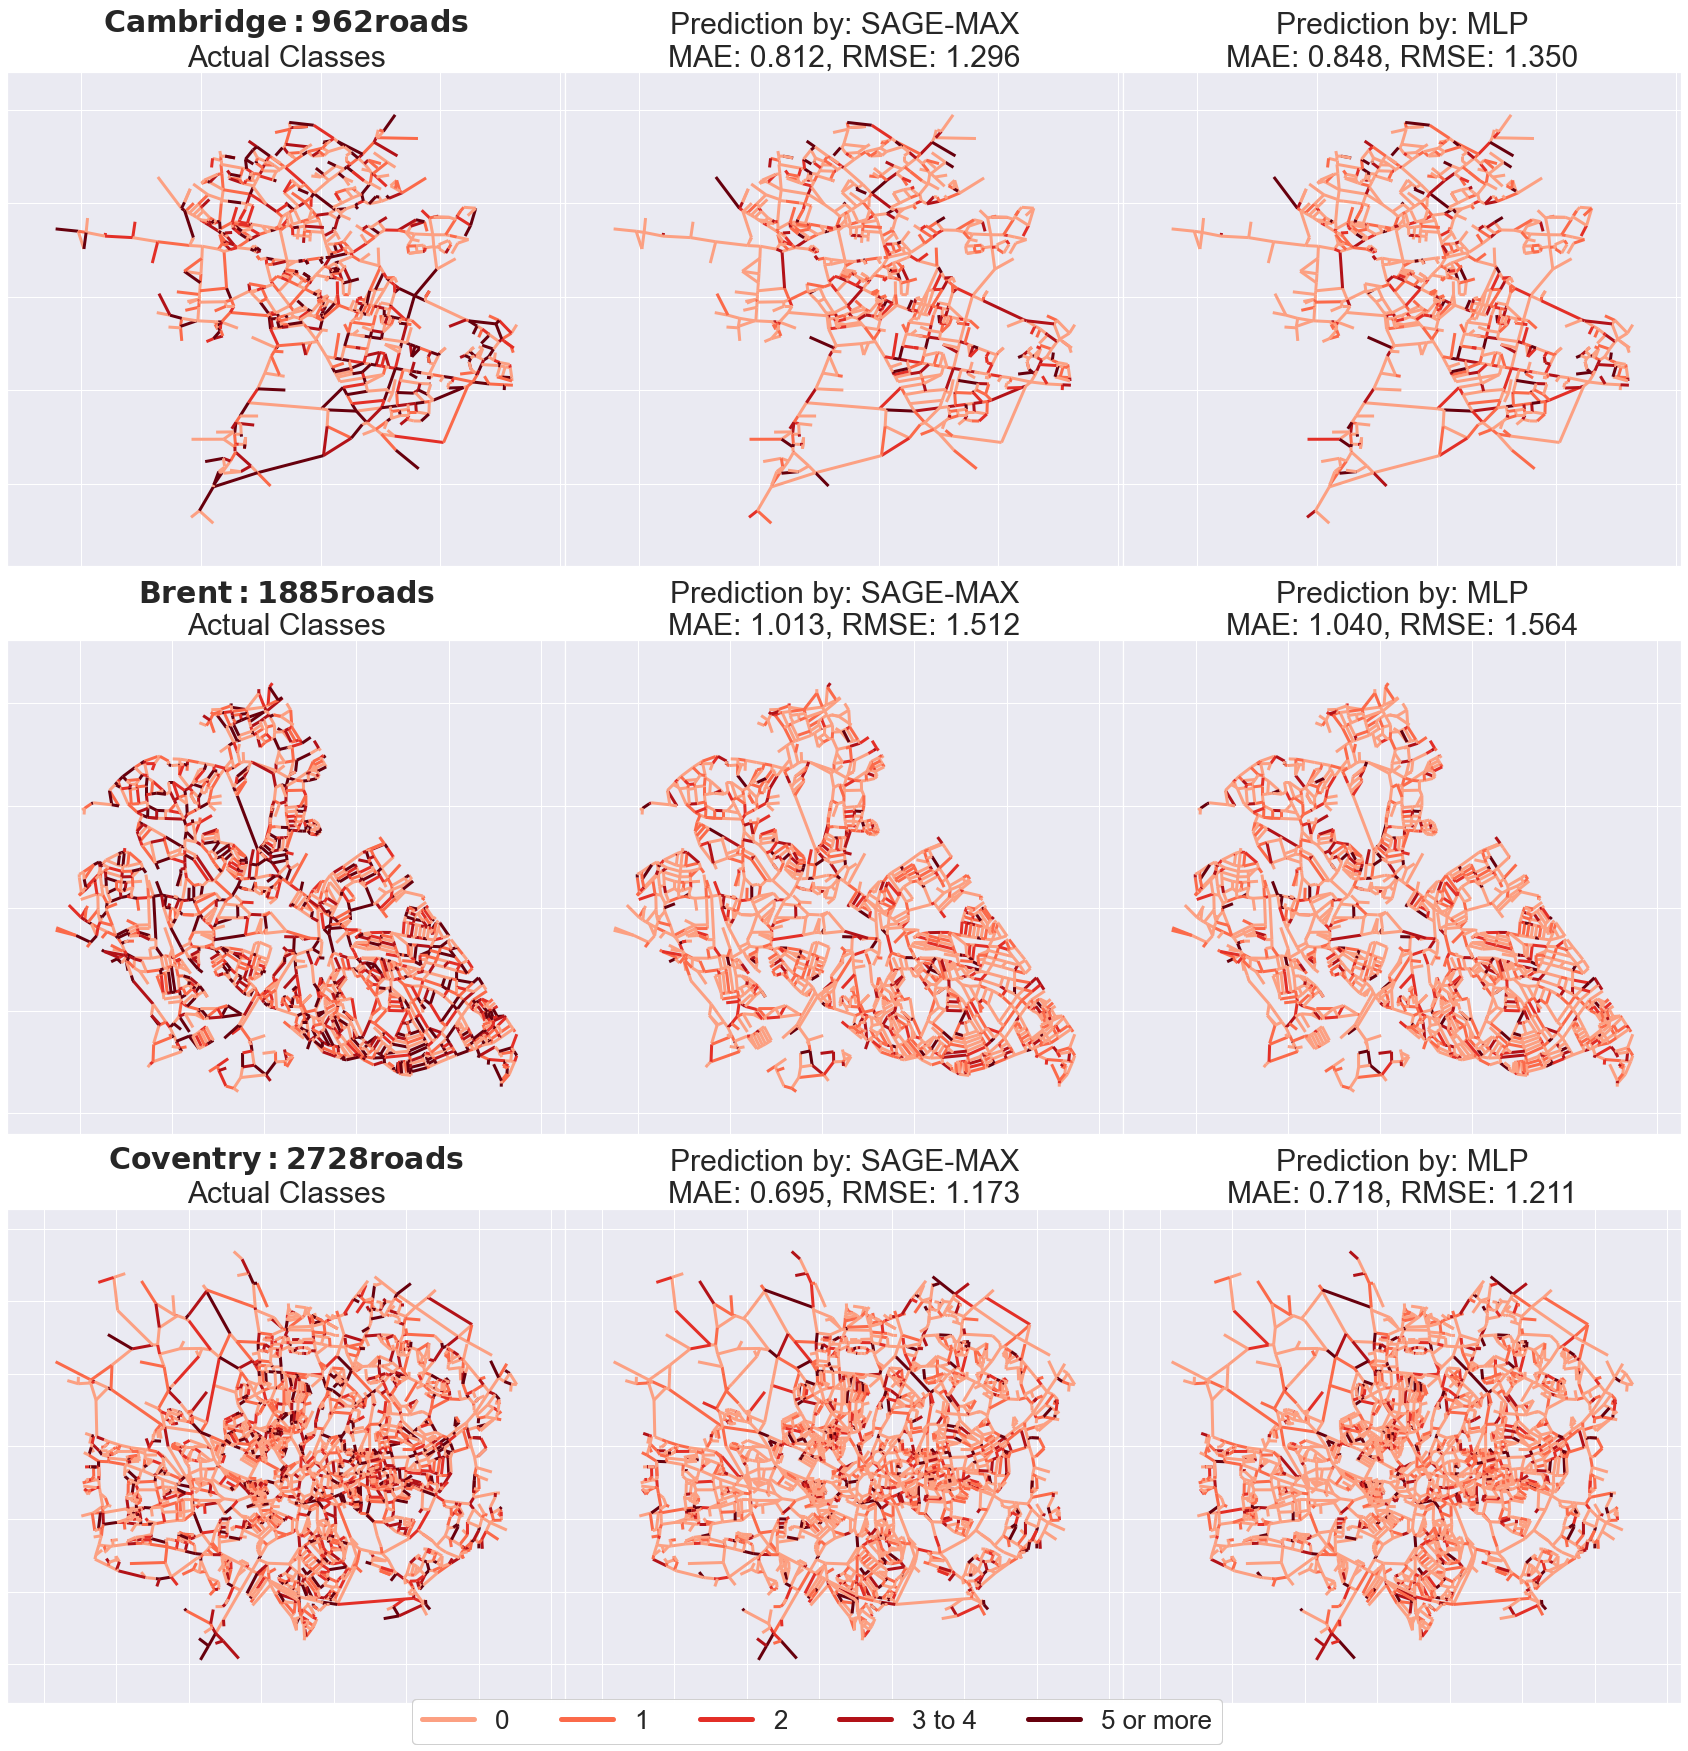

In [20]:
from matplotlib import cm
from matplotlib.lines import Line2D
# from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib
from coral_pytorch.dataset import proba_to_label
from utils.visualization import visualize_nx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# color_dict ={
#     '0': '#808080',
#     '1': '#440154', 
#     '2': '#31688e',
#     '3 to 4': '#35b779', 
#     '5 or more': '#fde725'
# }
n_classes = 5
cmap_name = 'Reds'
cmap = cm.get_cmap(cmap_name, n_classes + 2)    # PiYG

colors = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(2, cmap.N)]
labels = ['0', '1', '2', '3 to 4', '5 or more']
color_dict = { labels[i]: colors[i] for i in range(n_classes) }

target_field = 'accident_count'
clean = True
categorize = 'multiclass'
agg = 'min'
include_feats = all_feature_fields + ['meridian_class']
places = ['Cambridge', 'Brent', 'Coventry']
model_titles = ['SAGE-MAX', 'MLP']

custom_lines = [Line2D([0], [0], color=col, lw=lw) \
                for col, lw in zip(list(color_dict.values()), [5, 5, 5, 5, 5])]

def visualize_preds(places, models, metrics=[], model_titles=None,
                    only_pred=False):
    num_plots = len(models) + 1
    
    f = plt.figure(figsize=(num_plots*10, 10*len(places)))
    outer = gridspec.GridSpec(len(places), 1, wspace=0, hspace=0.15)
    for i, place in enumerate(places):
        data, _, _ = load_data(place,
                               target_field,
                               categorize=categorize,
                               include_feats=include_feats,
                               clean=clean,
                               agg=agg,
                                verbose=True)
        print(data.node_attrs, len(data.node_attrs))
        streets = load_graph(place, target_field=target_field,
                            feature_fields=all_feature_fields,
                             force_connected=True,
                             clean=clean,
                            return_nx=True)
        
        inner = gridspec.GridSpecFromSubplotSpec(1,num_plots,
                    subplot_spec=outer[i], wspace=0, hspace=0.05)    
        ax = plt.Subplot(f, outer[i])
        title = r"$\bf{" + f'{place}: {streets.number_of_nodes()} roads' + '}$'
        ax.axis('off')
        f.add_subplot(ax)

        # Convert nx graph to dgl (preserves node order) and get model predictions 
        data = data.to(device)
        metric_dict = {metric: [] for metric in metrics}
        mcc, f1 = [], []
        for idx, model in enumerate(models):
            target = data.y.cpu()
            logits, probas = model(data.x.float(), data.edge_index)
            preds = proba_to_label(probas).float()
            
            # Convert preds to label and assign to nx nodes
            pred_dict = {}
            target_dict = {}
            pred_classes = []
            for i, e in enumerate(streets.edges(keys=True)):
                pred = preds[i].item()
                pred_dict[e] = data.classes[int(pred)]
                target_dict[e] = data.classes[int(target[i])]
                pred_classes.append(pred)
            
            nx.set_edge_attributes(streets, target_dict, target_field)
            nx.set_edge_attributes(streets, pred_dict, f'preds_model_{idx + 1}')

            # Obtain metrics
            for metric in metrics:
                val = criteria_fns[metric](target, np.array(pred_classes))
                metric_dict[metric].append(val)

        # plot actual and predicted values
    
        target_fields = [target_field] + [f'preds_model_{idx + 1}' for idx in range(len(models))]
        for idx, field in enumerate(target_fields):
            ax = plt.Subplot(f, inner[idx], facecolor='#eaeaf2')
            colors = [color_dict[d[field]] for _, _, d in streets.edges(data=True)]
            # widths = [2 if d[field] == '0' else 5 for _, _, d in streets.edges(data=True)]
            visualize_nx(streets, ax=ax,
                         node_size=0,
                         width=3,
                         edge_color=colors)
            # ax.set_facecolor('')
            
            if idx == 0:
                subtitle = f'{title}\nActual Classes'
            else:
                idx = idx - 1
                subtitle = f'Prediction by: {model_titles[idx]}\n'
                subtitle += ', '.join(f'{metric}: {metric_dict[metric][idx]:.3f}' 
                                     for metric in metric_dict)
            ax.set_title(subtitle, size=30)
            # ax.axis("off")
            f.add_subplot(ax)
        
        f.legend(custom_lines, list(color_dict.keys()), facecolor='white',loc='lower center', bbox_to_anchor=(0.5, 0.1), fontsize='x-large', ncol=5)
        # plt.suptitle(title, fontweight="bold", fontsize=40, x=0.2, y=0.98)

print(model_dict)
sns.set(font_scale=1.5)
models = [model_dict[model_type][0] for model_type in model_dict]
visualize_preds(places, models, metrics=['MAE', 'RMSE'], model_titles=model_titles)
plt.tight_layout()
plt.savefig(f'{target_field}_pred.png', bbox_inches='tight')

# Visualize Meridian Class Preds

In [ ]:
from matplotlib.lines import Line2D
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef 
import pylab
import matplotlib.gridspec as gridspec


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
color_dict = {'motorway': '#d62728',
              'aroad': '#1f77b4',
              'broad': '#ff7f0e',
              'minor': '#7f7f7f'}

custom_lines = [Line2D([0], [0], color=col, lw=lw) for col, lw in zip(list(color_dict.values()), [5, 5, 5, 2])]

def visualize_preds(places, models, model_titles=None,
                    only_pred=False, target_field = 'meridian_class'):
    clean = target_field == 'meridian_class'
    num_plots = len(models) + 1
    
    f = plt.figure(figsize=(num_plots*10, 10*len(places)))
    outer = gridspec.GridSpec(len(places), 1, wspace=0.1, hspace=0.1)
    for i, place in enumerate(places):
        data, _, _ = load_data(place, target_field,
                           include_feats=unnorm_feature_fields,
                            clean=clean,
                            verbose=True)

        streets = load_graph(place, target_field=target_field,
                            feature_fields=all_feature_fields,
                             force_connected=True,
                             clean=clean,
                            return_nx=True)
        
        inner = gridspec.GridSpecFromSubplotSpec(1,num_plots,
                    subplot_spec=outer[i], wspace=0.05, hspace=0.05)    
        ax = plt.Subplot(f, outer[i])
        ax.set_title(f'{place}: {streets.number_of_nodes()} roads', fontsize=30, fontweight="bold", y=1.05, x=0.15)
        ax.axis('off')
        f.add_subplot(ax)

        # Convert nx graph to dgl (preserves node order) and get model predictions 
        data = data.to(device)
        mcc, f1 = [], []
        for idx, model in enumerate(models):
            preds = model(data.x.float(), data.edge_index)

            # Convert preds to label and assign to nx nodes
            pred_dict = {}
            pred_classes = []
            for i, e in enumerate(streets.edges()):
                pred = preds[i].argmax().item()
                pred_classes.append(pred)
                pred_dict[e] = data.classes[int(pred)]
            nx.set_edge_attributes(streets, pred_dict, f'preds_model_{idx + 1}')

            # Obtain metrics
            mcc.append(matthews_corrcoef(data.y.cpu(), np.array(pred_classes)))
            f1.append(f1_score(data.y.cpu(), np.array(pred_classes), average='weighted'))

        # Convert nx graph back to gdf
        lines = momepy.nx_to_gdf(streets)[1]

         # plot actual and predicted values
        # f, ax = plt.subplots(1, num_plots, figsize=(num_plots*10, 10), sharex=True, sharey=True)
        target_fields = [target_field] + [f'preds_model_{idx + 1}' for idx in range(len(models))]
        for idx, field in enumerate(target_fields):
            ax = plt.Subplot(f, inner[idx])
        
            minor_lines = lines[lines[field] == 'minor']
            other_lines = lines[lines[field] != 'minor']
            for g, lw, z in [(minor_lines, 2, 1), (other_lines, 5, 2)]:
                colors = [color_dict[cat] for cat in g[field]]
                g.plot(ax=ax, column=field, colors=colors, linewidth=lw, zorder=z)
            
            if idx == 0:
                subtitle = 'Actual Classes'
            else:
                idx = idx - 1
                subtitle = f'Prediction by: {model_titles[idx]}\n' \
                     f'Wt. F1: {f1[idx]:.3f}, MCC: {mcc[idx]:.3f}'
            ax.set_title(subtitle, size=30)
            ax.axis("off")
            f.add_subplot(ax)
        
        f.legend(custom_lines, list(color_dict.keys()),
                 loc='lower center', bbox_to_anchor=(0.5, 0.1), fontsize='x-large', ncol=4)
        # plt.suptitle(title, fontweight="bold", fontsize=40, x=0.2, y=0.98)

places = ['Cambridge', 'Coventry', 'Birmingham']
model_titles = ['SAGE-MIN', 'MLP']
print(model_dict)
sns.set(font_scale=1.5)
models = [model_dict[model_type][0] for model_type in model_dict]
visualize_preds(places, models, model_titles=model_titles, target_field='meridian_class')
plt.tight_layout()
plt.savefig('meridian_pred.png')

In [20]:
target_field = 'accident_count'
data.node_attrs

['metres',
 'mid_x',
 'mid_y',
 'geom0_x',
 'geom0_y',
 'geom1_x',
 'geom1_y',
 'geom2_x',
 'geom2_y',
 'geom3_x',
 'geom3_y',
 'geom4_x',
 'geom4_y',
 'choice2km',
 'nodecount2km',
 'integration2km',
 'choice10km',
 'nodecount10km',
 'integration10km',
 'choice100km',
 'nodecount100km',
 'integration100km',
 'choice2kmrank',
 'choice10kmrank',
 'integration10kmrank',
 'integration2kmrank',
 'choice2kmlog',
 'choice10kmlog',
 'choice100kmlog',
 'meridian_class_aroad',
 'meridian_class_broad',
 'meridian_class_minor',
 'meridian_class_motorway']

In [ ]:
float32_node_dict = {(torch.tensor(c[0], dtype=torch.float32).item(),
                          torch.tensor(c[1], dtype=torch.float32).item()): c for c in streets}
    count_dict = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
    enhanced_count_dict = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
    data = original_data
    
    # Iterate over predicted edges (which includes real and fake edges)
    for i, pred in enumerate(preds):
        enhanced_pred = enhanced_preds[i]

        # Get indices of both the nodes of the edge
        u_idx, v_idx = cat_index[:, i]
        
        # Get their coordinates (the last two node attributes in pretransformed data)
        u_float32 = data.x[u_idx, -2].item(), data.x[u_idx, -1].item()
        v_float32 = data.x[v_idx, -2].item(), data.x[v_idx, -1].item()
        # Convert them into their full precision node coordinates
        u, v = float32_node_dict[u_float32], float32_node_dict[v_float32]